# Text Summarization

Text summarization is the process of condensing a longer piece of text into a shorter version while preserving the main ideas and key information. It aims to capture the essence of the original text and present it in a concise and coherent manner. The goal of text summarization is to save time and effort for readers by providing a summary that captures the most important points of the document.

# Two types of Text Summarization

* **Extractive Summarization**: This approach involves selecting the most relevant sentences or phrases from the original text and combining them to form a summary. Extractive summarization methods typically rank sentences based on their importance, using techniques such as frequency analysis, statistical methods, or machine learning algorithms. The selected sentences are then arranged to create a coherent summary.

* **Abstractive Summarization**: In contrast to extractive summarization, abstractive summarization aims to generate a summary that may contain words, phrases, or even sentences that were not present in the original text. It involves understanding the meaning of the text and generating a summary in a more human-like manner. Abstractive methods often employ natural language processing (NLP) techniques, such as language generation models, to paraphrase and generate new sentences that capture the essential information.

# Building Text Summarizer using Transformer

In this notebook we will build Text summarizer (Abstractive Summarization) using **Transformer Encoder-Decoder architecture**, we will train on BBC News Summary dataset which contains 2225 pairs of news and its summaries.

# BART Architecture

**BART (Bidirectional and Auto-Regressive Transformers)** is a pre-trained sequence-to-sequence model that combines the best of BERT and GPT:

**Architecture Flow:**
```
Article → BART Encoder (Bidirectional) → Latent Representation → BART Decoder (Auto-Regressive) → Summary
```

**Key Components:**
- **Encoder**: Bidirectional Transformer (like BERT) that reads the entire input
- **Decoder**: Auto-regressive Transformer (like GPT) that generates the summary token by token
- **Pre-training**: Trained on denoising tasks (text infilling, sentence permutation)
- **Fine-tuning**: Can be adapted to summarization with minimal additional training

**Advantages over custom Transformers:**
- Pre-trained on large corpora with rich language understanding
- Better performance with less training data
- Built-in optimizations and generation strategies

# Importing the requirements

In [ ]:
!pip install rouge_score
!pip install evaluate
!pip install kagglehub

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=0d393035981ab617e554bbb412340a0e5157e4b65879c842a780d6c4e227e913
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer
from transformers import BartForConditionalGeneration
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

import datasets
from datasets import Dataset as HFDataset
from datasets import DatasetDict

from tqdm import tqdm
import kagglehub

import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt")
nltk.download("punkt_tab") # Add this line to download the missing resource

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Download Dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("pariza/bbc-news-summary")

print("Path to dataset files:", path)

100%|██████████| 8.91M/8.91M [00:01<00:00, 6.15MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pariza/bbc-news-summary/versions/2


# Data Analysis

In [ ]:
paths = os.listdir(os.path.join(path, 'BBC News Summary/News Articles'))
articles_path = os.path.join(path, 'BBC News Summary/News Articles/')
summaries_path = os.path.join(path, 'BBC News Summary/Summaries/')

articles = []
summaries = []
file_arr = []

for p in paths:
    files = os.listdir(articles_path + p)
    for file in files:
        article_file_path = articles_path + p + '/' + file
        summary_file_path = summaries_path + p + '/' + file
        try:
            with open(article_file_path, 'r', encoding='utf-8', errors='ignore') as f:
                articles.append('.'.join([line.rstrip() for line in f.readlines()]))
            with open(summary_file_path, 'r', encoding='utf-8', errors='ignore') as f:
                summaries.append('.'.join([line.rstrip() for line in f.readlines()]))
            file_arr.append(p + '/' + file)
        except:
            pass

In [ ]:
df = pd.DataFrame({'path': file_arr, 'article': articles, 'summary': summaries})
df.head()

,path,article,summary
0,entertainment/188.txt,Celebrities get their skates on..Former Englan...,Ice skating duo Jayne Torvill and Christopher ...
1,entertainment/053.txt,Horror film heads US box office..A low-budget ...,"This year, the top 12 films grossed around $91..."
2,entertainment/144.txt,Eminem beats Elvis to number one..Rapper Emine...,"Last week's number one, Elvis's It's Now or Ne..."
3,entertainment/111.txt,Elton plays Paris charity concert..Sir Elton J...,Sir Elton John has performed at a special conc...
4,entertainment/235.txt,Pop band Busted to 'take a break'..Chart-toppi...,Chart-topping pop band Busted have confirmed t...


In [ ]:
# removing nans if any

df.dropna(inplace=True)
df.isnull().sum()

,0
path,0
article,0
summary,0


In [ ]:
# creating function to count the words in each sample

def word_count(sentence):
    sentences = sentence.split()
    return len(sentences)

In [ ]:
# creating new columns of word numbers

df['num_words_article'] = df['article'].apply(word_count)
df['num_words_summary'] = df['summary'].apply(word_count)
df.head()

,path,article,summary,num_words_article,num_words_summary
0,entertainment/188.txt,Celebrities get their skates on..Former Englan...,Ice skating duo Jayne Torvill and Christopher ...,218,110
1,entertainment/053.txt,Horror film heads US box office..A low-budget ...,"This year, the top 12 films grossed around $91...",260,110
2,entertainment/144.txt,Eminem beats Elvis to number one..Rapper Emine...,"Last week's number one, Elvis's It's Now or Ne...",193,90
3,entertainment/111.txt,Elton plays Paris charity concert..Sir Elton J...,Sir Elton John has performed at a special conc...,236,125
4,entertainment/235.txt,Pop band Busted to 'take a break'..Chart-toppi...,Chart-topping pop band Busted have confirmed t...,251,96


In [ ]:
# getting statistical info about the word lengths

df.describe()

,num_words_article,num_words_summary
count,2225.000000,2225.000000
mean,379.314607,165.166742
std,235.032779,108.655971
min,87.000000,38.000000
25%,242.000000,103.000000
50%,327.000000,142.000000
75%,465.000000,202.000000
max,4377.000000,2073.000000


Upper whisker: 799.0
Q3: 465.0
Q2: 327.0
Q1: 242.0
Lower whisker: 87.0


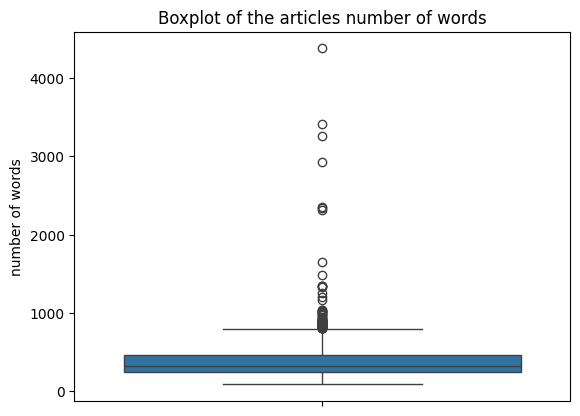

In [ ]:
sns.boxplot(df["num_words_article"])
plt.ylabel("number of words")
plt.title("Boxplot of the articles number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1, Q3, article_lower_whisker, article_upper_whisker, Q2 = all_lines

print("Upper whisker:", article_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", article_lower_whisker)

Upper whisker: 350.0
Q3: 202.0
Q2: 142.0
Q1: 103.0
Lower whisker: 38.0


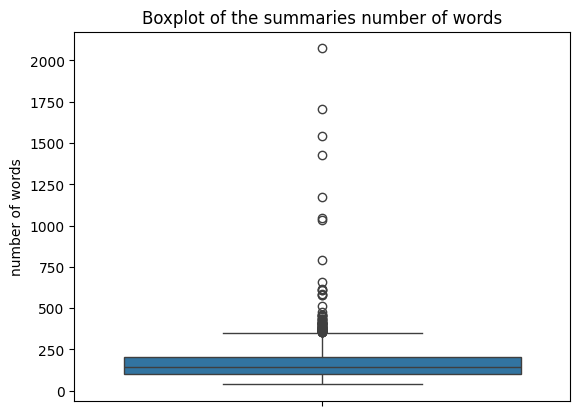

In [ ]:
sns.boxplot(df["num_words_summary"])
plt.ylabel("number of words")
plt.title("Boxplot of the summaries number of words")

lines = plt.gca().lines[:6]
all_lines = [lines[i].get_ydata()[0] for i in range(5)]

Q1, Q3, summary_lower_whisker, summary_upper_whisker, Q2 = all_lines

print("Upper whisker:", summary_upper_whisker)
print("Q3:", Q3)
print("Q2:", Q2)
print("Q1:", Q1)
print("Lower whisker:", summary_lower_whisker)

In [ ]:
# removing the samples of very long sequences

new_df = df[(df['num_words_summary'] <= summary_upper_whisker) & (df['num_words_article'] <= article_upper_whisker)]
new_df

,path,article,summary,num_words_article,num_words_summary
0,entertainment/188.txt,Celebrities get their skates on..Former Englan...,Ice skating duo Jayne Torvill and Christopher ...,218,110
1,entertainment/053.txt,Horror film heads US box office..A low-budget ...,"This year, the top 12 films grossed around $91...",260,110
2,entertainment/144.txt,Eminem beats Elvis to number one..Rapper Emine...,"Last week's number one, Elvis's It's Now or Ne...",193,90
3,entertainment/111.txt,Elton plays Paris charity concert..Sir Elton J...,Sir Elton John has performed at a special conc...,236,125
4,entertainment/235.txt,Pop band Busted to 'take a break'..Chart-toppi...,Chart-topping pop band Busted have confirmed t...,251,96
...,...,...,...,...,...
2220,sport/237.txt,English clubs make Euro history..All four of E...,"The favourites are Chelsea and Barcelona, and ...",169,87
2221,sport/506.txt,Rusedski forced out in Marseille..Greg Rusedsk...,Greg Rusedski was forced to withdraw from the ...,128,52
2222,sport/206.txt,Anelka 'eyes Man City departure'..Striker Nico...,"""Playing for eighth place is good but I miss t...",261,114
2223,sport/048.txt,Greek pair set for hearing..Kostas Kenteris an...,Kenteris and Thanou also face criminal charges...,418,154


# Preparing the data

We will train on a subset of the dataset for demonstration

In [ ]:
# deleting some columns and shuffling the rows

new_df = new_df.drop(columns=["num_words_article", "num_words_summary", "path"])
new_df = new_df.sample(frac=0.3, random_state=42)  # Using 30% of data
new_df = new_df.reset_index(drop=True)
new_df.head()

,article,summary
0,Edwards tips Idowu for Euro gold..World outdoo...,World outdoor triple jump record holder and BB...
1,Everton's Weir cools Euro hopes..Everton defen...,Everton defender David Weir has played down ta...
2,Tautou 'to star in Da Vinci film'..French actr...,"French actress Audrey Tautou, star of hit film..."
3,Help for indies in download sales..A campaign ...,The British Phonographic Industry has identifi...
4,S Korean lender faces liquidation..Creditors o...,"""Creditors would seek strong financial sanctio..."


In [ ]:
# splitting the data into train and test

ratio = 0.8
split = int(len(new_df) * ratio)

train_df = new_df.iloc[:split]
test_df = new_df.iloc[split:]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Train size: 515
Test size: 129


In [ ]:
# convert the DataFrame into DatasetDict

train_dataset = HFDataset.from_pandas(train_df)
test_dataset = HFDataset.from_pandas(test_df)
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'summary'],
        num_rows: 515
    })
    test: Dataset({
        features: ['article', 'summary'],
        num_rows: 129
    })
})

# Tokenizer Setup

In [ ]:
# Using BART tokenizer for consistency
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

max_input_length = int(article_upper_whisker)
max_target_length = int(summary_upper_whisker)

print(f"Max article length: {max_input_length}")
print(f"Max summary length: {max_target_length}")

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Max article length: 799
Max summary length: 350


In [ ]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["article"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["article", "summary"]
)

Map:   0%|          | 0/515 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

# Load Pre-trained BART Model

In [ ]:
# Load pre-trained BART model
model_checkpoint = "facebook/bart-base"
model = BartForConditionalGeneration.from_pretrained(model_checkpoint).to(device)

print(f"Loaded BART model: {model_checkpoint}")
print(f"Model device: {next(model.parameters()).device}")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Loaded BART model: facebook/bart-base
Model device: cuda:0
Total parameters: 139,420,416
Trainable parameters: 139,420,416


# ROUGE

ROUGE, or Recall-Oriented Understudy for Gisting Evaluation, is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation.

**Inputs:**
* predictions (list): list of predictions to score. Each prediction should be a string with tokens separated by spaces.
* references (list or list[list]): list of reference for each prediction. Each reference should be a string with tokens separated by spaces.
* rouge_types (list): A list of rouge types to calculate. Valid rouge types:
  - "rouge1": unigram (1-gram) based scoring
  - "rouge2": bigram (2-gram) based scoring
  - "rougeL": Longest common subsequence based scoring
  - "rougeLsum": splits text using "\n"

In [ ]:
import evaluate

rouge_score = evaluate.load("rouge")

In [ ]:
# example on using rouge

generated_summary = "I absolutely loved reading the Hunger Games"
reference_summary = "I loved reading the Hunger Games"
scores = rouge_score.compute(predictions=[generated_summary], references=[reference_summary])
scores

{'rouge1': np.float64(0.923076923076923),
 'rouge2': np.float64(0.7272727272727272),
 'rougeL': np.float64(0.923076923076923),
 'rougeLsum': np.float64(0.923076923076923)}

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]

    # Compute ROUGE scores
    result = rouge_score.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    return {k: round(v, 4) for k, v in result.items()}

# Fine-tuning Transformer with BBC News dataset

In [ ]:
# creating data_collator
# A data_collator is a function that takes a batch of data and collates it into a format suitable for model training

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding=True)

# The columns 'article' and 'summary' have already been transformed and removed by the previous map operation.
# Therefore, the following line is redundant and causes a ValueError if the columns are already absent.
# tokenized_datasets = tokenized_datasets.remove_columns(dataset["train"].column_names)

In [ ]:
batch_size = 4
num_train_epochs = 10
logging_steps = len(tokenized_datasets["train"]) // batch_size
model_name = "bart-base-summarizer"

args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-BBC",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    fp16=torch.cuda.is_available(),
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
)

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,0.432100,0.206588,0.169100,0.137900,0.161000,0.160700
2,0.240900,0.179745,0.171800,0.138900,0.162800,0.163100
3,0.198100,0.175929,0.181600,0.157500,0.175800,0.175900
4,0.175900,0.176998,0.183900,0.162800,0.179700,0.179700
5,0.149300,0.172454,0.188700,0.170100,0.185400,0.184800
6,0.129700,0.177248,0.190700,0.174500,0.188400,0.188300
7,0.113200,0.178808,0.192300,0.173400,0.188200,0.187300
8,0.106700,0.179363,0.190700,0.174200,0.188500,0.188300
9,0.096500,0.182204,0.189000,0.170600,0.186300,0.186200
10,0.086700,0.182983,0.190500,0.172900,0.188000,0.187600


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=1290, training_loss=0.17227497271789136, metrics={'train_runtime': 685.9612, 'train_samples_per_second': 7.508, 'train_steps_per_second': 1.881, 'total_flos': 1899242727782400.0, 'train_loss': 0.17227497271789136, 'epoch': 10.0})

# Inference

In [ ]:
def generate_summary(model, tokenizer, article, max_length=None, device='cuda'):
    """
    Generate summary using BART model.
    BART has built-in generate() method that handles everything automatically.
    """
    if max_length is None:
        max_length = max_target_length

    model.eval()

    # Tokenize article
    inputs = tokenizer(
        article,
        max_length=max_input_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to(device)

    # Generate summary using BART's built-in generate method
    with torch.no_grad():
        summary_ids = model.generate(
            inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_length,
            num_beams=4,  # Beam search for better quality
            early_stopping=True,
            no_repeat_ngram_size=3,  # Avoid repetition
        )

    # Decode the generated summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [ ]:
def print_summary(idx):
    article = dataset["test"][idx]["article"]
    summary = dataset["test"][idx]["summary"]
    g_summary = generate_summary(model, tokenizer, article, device=device)
    score = rouge_score.compute(predictions=[g_summary], references=[summary])
    scores = {k: round(v, 4) for k, v in score.items()}
    print(f">>> Article: {article[:500]}...")
    print(f"\n>>> Summary: {summary}")
    print(f"\n>>> Generated Summary: {g_summary}")
    print(f"\n>>> ROUGE Score: {scores}")

print_summary(1)

>>> Article: Top Tories on Lib Dem 'hit list'..The Liberal Democrats are aiming to unseat a string of top Tories - including leader Michael Howard - at the next general election...Mr Howard's seat is at the top of the Liberal Democrats' list. Others targeted include Oliver Letwin, David Davis and Theresa May, Lib Dem's elections chief Lord Rennard said. He said it was "nothing personal" but that "very many of the prominent Conservatives" had slender leads in seats where the Lib Dems were second...In 2001, Mi...

>>> Summary: A Conservative spokesperson said: "The Liberal Democrats can talk all they like about strategy.Mr Howard's seat is at the top of the Liberal Democrats' list.He said it was "nothing personal" but that "very many of the prominent Conservatives" had slender leads in seats where the Lib Dems were second.In 2001, Michael Howard won the Folkestone & Hythe seat with 20,645 votes, compared to 14,738 for the Liberal Democrat candidate Peter Carroll, giving the Tory leader a

# Save Model

In [ ]:
# Save the fine-tuned BART model using Hugging Face's save method
output_dir = "./bart-summarizer-final"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}!")
print("\nTo load the model later, use:")
print(f"model = BartForConditionalGeneration.from_pretrained('{output_dir}')")
print(f"tokenizer = AutoTokenizer.from_pretrained('{output_dir}')")

Model and tokenizer saved to ./bart-summarizer-final!

To load the model later, use:
model = BartForConditionalGeneration.from_pretrained('./bart-summarizer-final')
tokenizer = AutoTokenizer.from_pretrained('./bart-summarizer-final')


# References

* HuggingFace Transformers: https://huggingface.co/docs/transformers/
* HuggingFace NLP course: https://huggingface.co/learn/nlp-course/
* Rouge metric: https://huggingface.co/spaces/evaluate-metric/rouge
* Attention Is All You Need: https://arxiv.org/abs/1706.03762